# Is there a statistically significant difference between the scores of albums in the jazz and metal genres?

$H_O$: Jazz albums have the same average score as metal albums. 

$H_a$: Jazz albums $do$ $not$ have the same average score as metal albums.

$\alpha$: 0.05 

# Data Extraction

Having previously created a PostgreSQL database containing this [Kaggle dataset](https://www.kaggle.com/nolanbconaway/pitchfork-data) of Pitchfork album reviews, we need only to load it.

In [1]:
import psycopg2
from sqlalchemy import create_engine
import pandas as pd
import numpy as np
from scipy import stats
from statsmodels.stats.weightstats import ztest
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')
import seaborn as sns

In [2]:
# Connect to PostgreSQL database containing Pitchfork review data

engine = create_engine('postgres:///music')
conn = engine.connect()
engine.table_names()

['reviews', 'artists', 'genres', 'labels', 'years', 'content']

In [3]:
def postgres_to_df(table_name):
    """Return a Pandas DataFrame generated from an PostgreSQL table."""
    result = conn.execute(f'SELECT * FROM {table_name}')
    columns = [x for x in result.keys()]
    df = pd.DataFrame(result.fetchall(), columns=columns)
    return df

In [4]:
reviews = postgres_to_df('reviews')
len(reviews)

18393

In [5]:
# Build a dataframe containing info on album genre and ratings.

query = """
SELECT
    reviews.score,
    reviews.reviewid,
    genres.genre
FROM
    reviews
FULL OUTER JOIN genres ON reviews.reviewid = genres.reviewid
ORDER BY reviews.reviewid
"""
result = conn.execute(query)
df = pd.DataFrame(result.fetchall(), columns=result.keys())

# Data Investigation & Manipulation

After querying our database, we take a brief look at the mean scores of a number of genres. This is to see if we might want to investigate these further in the future. 

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22690 entries, 0 to 22689
Data columns (total 3 columns):
score       22690 non-null float64
reviewid    22690 non-null int64
genre       20319 non-null object
dtypes: float64(1), int64(1), object(1)
memory usage: 531.9+ KB


In [7]:
# Drop the 2,371 rows containing NaN genre values

df.dropna(inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20319 entries, 0 to 22689
Data columns (total 3 columns):
score       20319 non-null float64
reviewid    20319 non-null int64
genre       20319 non-null object
dtypes: float64(1), int64(1), object(1)
memory usage: 635.0+ KB


In [8]:
# Pull out all entries on jazz/metal albums into their own DataFrames

metal = df[df['genre'] == 'metal']
jazz = df[df['genre'] == 'jazz']
len(df), len(metal), len(jazz)

(20319, 862, 435)

In [9]:
metal['score'].mean(), jazz['score'].mean(), df['score'].mean()

(6.949999999999989, 7.303908045977008, 6.9880309070327815)

In [10]:
metal['score'].std(), jazz['score'].std(), df['score'].std()

(1.387799417840332, 1.2511039883565465, 1.314613606267048)

/Users/flatironschool/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


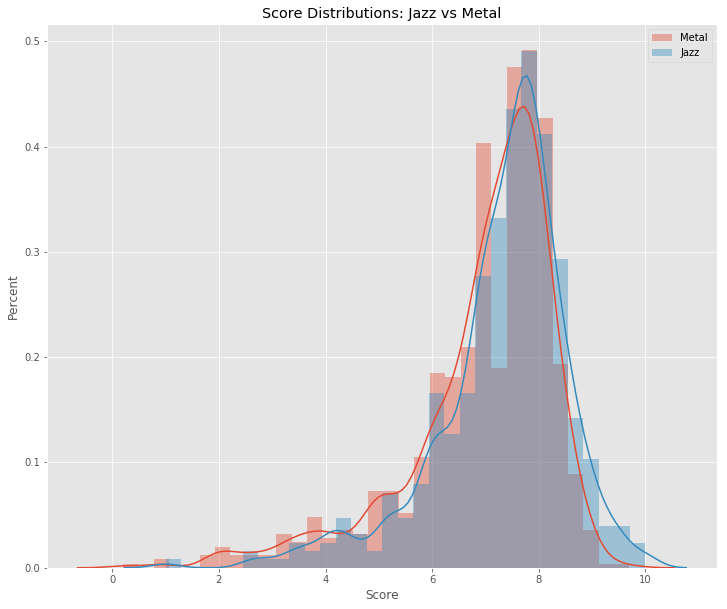

In [11]:
plt.figure(figsize=(12, 10))
plt.title('Score Distributions: Jazz vs Metal')
sns.distplot(metal['score'], label='Metal')
sns.distplot(jazz['score'], label='Jazz')
plt.xlabel('Score')
plt.ylabel('Percent')
plt.legend();

In [12]:
len(jazz), len(metal)

(435, 862)

In [13]:
# Take a random sample from metal equal to the number of entries in jazz
metal_sample = np.random.choice(metal['score'], len(jazz))

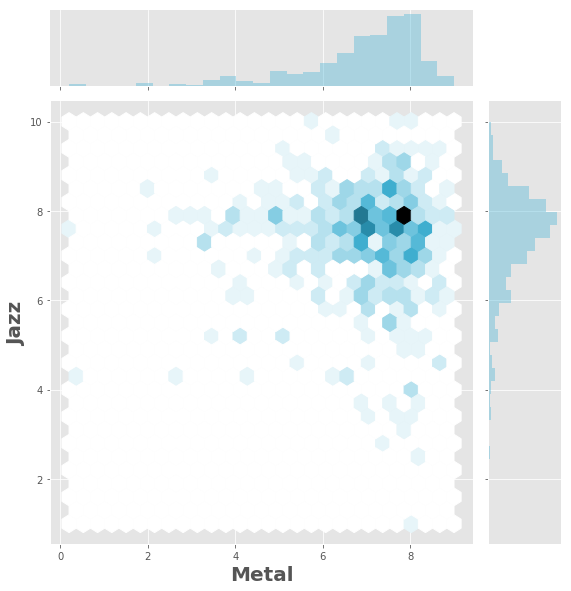

In [14]:
jp = sns.jointplot(x=metal_sample, y=jazz['score'], kind='hex', color='#50b7d6', height=8)
jp.set_axis_labels('Metal', 'Jazz', fontsize=20, fontweight='bold');

## Examining other genres

Although our hypothesis testing is limited strictly to jazz vs metal, we decide to investigate statistics on all genres in the dataset. This may open up additional avenues of investigation to pursue in the future.

In [15]:
genre_scores, genre_names = [], []
for genre in df['genre'].unique():
    genre_score = df[df['genre'] == genre]['score'].mean()
    print(f'Genre: {genre.title()}')
    print(f'Score: {round(genre_score, 2)}\n')
    genre_scores.append(genre_score)
    genre_names.append(genre.title())

Genre: Rock
Score: 6.94

Genre: Electronic
Score: 6.92

Genre: Jazz
Score: 7.3

Genre: Metal
Score: 6.95

Genre: Rap
Score: 6.9

Genre: Experimental
Score: 7.34

Genre: Pop/R&B
Score: 6.88

Genre: Global
Score: 7.43

Genre: Folk/Country
Score: 7.2



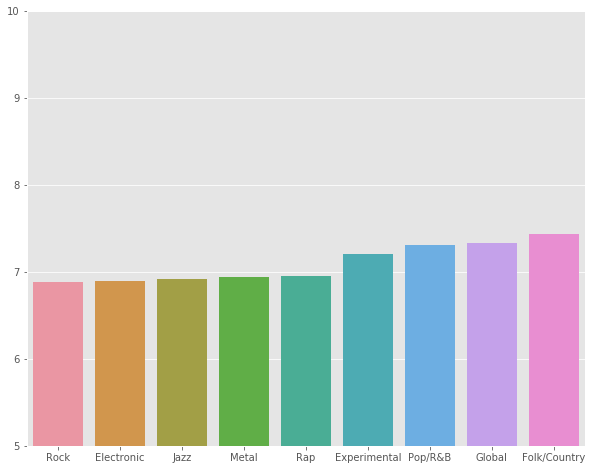

In [16]:
plt.figure(figsize=(10, 8))
plt.ylim(5, 10)
sns.barplot(genre_names, sorted(genre_scores));

In [17]:
query = """
SELECT 
    score, 
    genre 
FROM 
    reviews 
JOIN genres ON reviews.reviewid = genres.reviewid
"""
result = conn.execute(query)
genre_scores = pd.DataFrame(result.fetchall(), columns=result.keys())
genre_scores.head()

,score,genre
0,9.3,electronic
1,7.9,metal
2,7.3,rock
3,9.0,rock
4,8.1,electronic


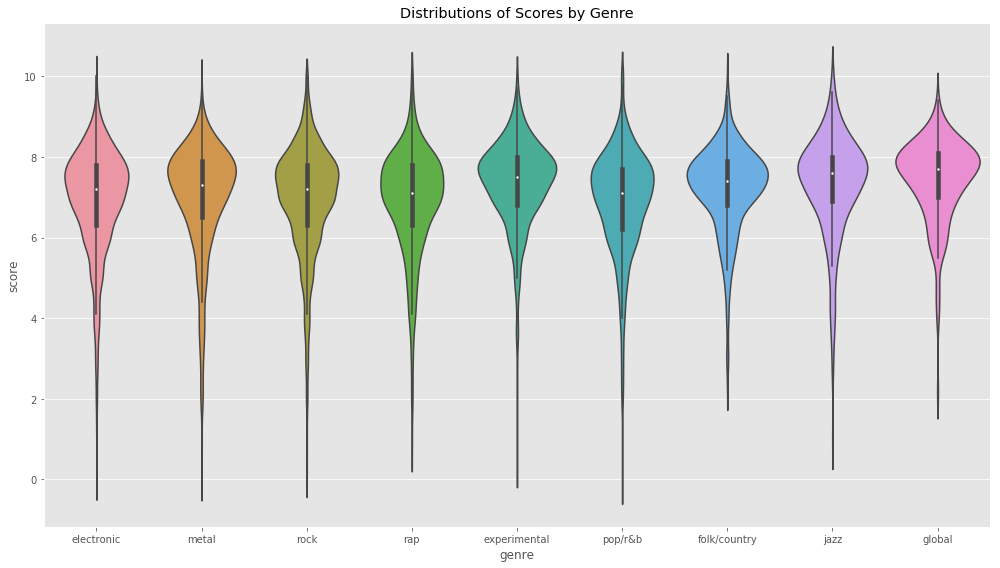

In [18]:
plt.figure(figsize=(14, 8))
plt.title('Distributions of Scores by Genre')
sns.violinplot(x='genre', y='score', data=genre_scores)
plt.tight_layout();

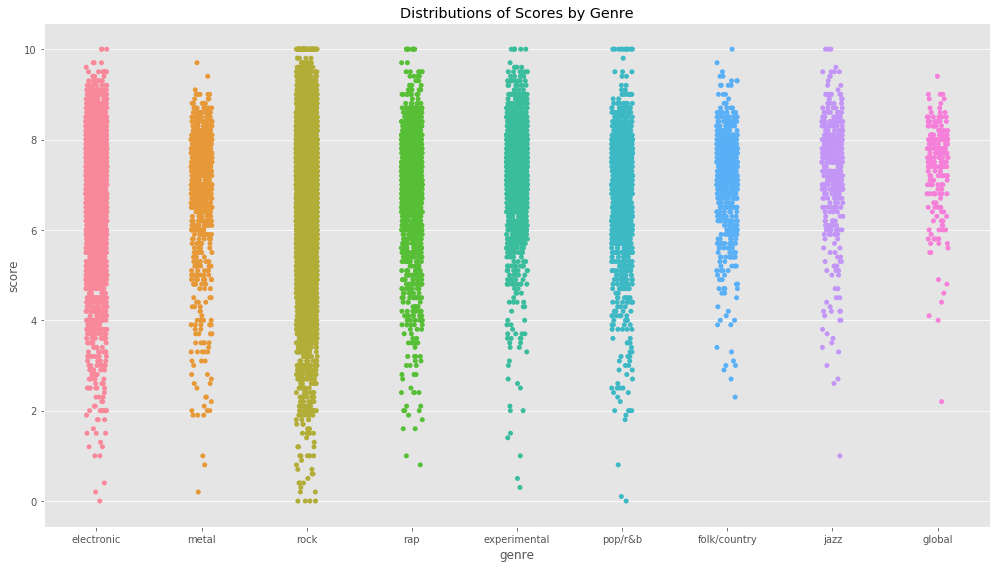

In [19]:
plt.figure(figsize=(14, 8))
plt.title('Distributions of Scores by Genre')
sns.stripplot(x='genre', y='score', data=genre_scores)
plt.tight_layout();

## Bootstrapping

As further investigation of the differences (or lack thereof) between the mean scores of jazz and metal, we perform bootstrapping. We sample 10^4 of our score data _with replacement_ and calculate the means of those samples. The resulting datasets form two barely-overlapping distributions.

In [20]:
def bootstrap_proportion(data, n_bootstraps=10**4):
    """Return array of sample means from bootstrapping n_bootstraps times."""
    output = np.zeros(n_bootstraps)
    n = len(data)
    for i in range(n_bootstraps):
        bootstrap_sample = np.random.choice(data, size=n)
        output[i] = (bootstrap_sample.sum() / n)
    return output

In [21]:
jazz_dist = bootstrap_proportion(jazz['score'])
metal_dist = bootstrap_proportion(metal['score'])

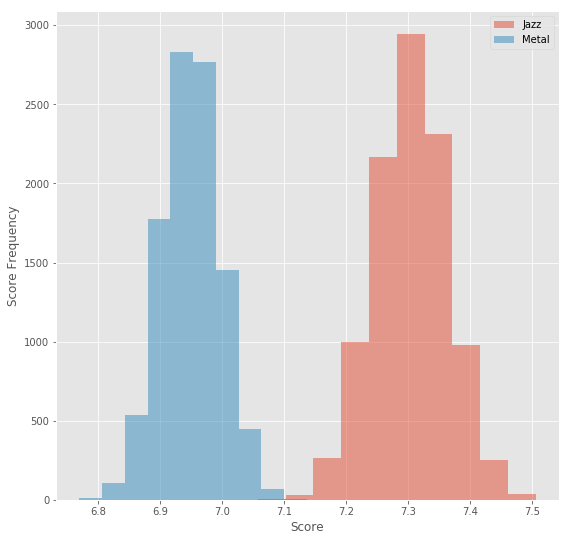

In [22]:
fig, ax = plt.subplots(figsize=(9, 9))
ax.hist(jazz_dist, alpha=.5, label='Jazz')
ax.hist(metal_dist, alpha=.5, label='Metal')
ax.legend()
ax.set_xlabel('Score')
ax.set_ylabel('Score Frequency')
plt.show();

# Calculating test statistic

Since score is principally a continuous value and we are comparing two samples, a two-sample z-test is appropriate.

In [23]:
z, p_value = ztest(jazz['score'], metal['score'])
z, p_value

(4.478871960286408, 7.503852439173003e-06)

This incredibly small p-value represents a chance barely better than 1-in-10-million that these distributions are, as per our null hypothesis, the same.

# Conclusion:
**Our p-value is well below our alpha of 0.05, so we confidently reject our null hypothesis.** It would seem that genre has a significant correlation with score, at least in the case of jazz vs metal.